<a href="https://colab.research.google.com/github/darkwings/ai-notebooks/blob/main/FindPerson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langchain_community langchain_core

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


Imposto il tool per la decodifica del codice fiscale

In [ ]:
from typing import Literal
from typing_extensions import TypedDict

class TaxCode(TypedDict):
    first_name: str
    last_name: str
    birth_date: str
    birth_city: str
    sex: Literal['M', 'F']


def decode_tax_code(tax_code: str) -> TaxCode:
    """Decodifica il codice fiscale italiano

    Parametri di input:
       tax_code: codice fiscale italiano da decodificare
    """

    # FAKE, qui ci andrebbe la chiamata al tool di decodifica, per determinare
    # sesso, luogo e data di nascita. Come esempio costruiamo un JSON fittizio
    return {"first_name": "FNC", "last_name": "TRR", "birth_date": "1990-01-01", "birth_city": "Pavia", "sex": "M"}


def verify_tax_code(first_name: str, last_name: str, tax_code: str) -> bool:
    """Verifica codice fiscale. Questa funzione controlla se il nome e cognome individuato
    soddisfano il codice fiscale individuato nel testo

    Parametri di input:
       first_name: il nome individuato  nel testo
       last_name: il cognome individuato nel testo
       tax_code: codice fiscale individuato nel testo
    """

    # Qui vanno implementate le solite regole di validazione del codice fiscale relativamente a nome e cognome
    # Generato da AI per velocizzare...
    def get_consonants(string):
        return ''.join(c for c in string.upper() if c.isalpha() and c not in 'AEIOU')

    def get_vowels(string):
        return ''.join(c for c in string.upper() if c in 'AEIOU')

    def get_name_code(string):
        consonants = get_consonants(string)
        vowels = get_vowels(string)

        # If there are more than 3 consonants, take the first, third and fourth
        if len(consonants) > 3:
            return consonants[0] + consonants[2] + consonants[3]

        # If there are exactly 3 consonants, use all of them
        if len(consonants) == 3:
            return consonants

        # If there are less than 3 consonants, add necessary vowels
        code = consonants + vowels

        # If the string is still too short, add X
        while len(code) < 3:
            code += 'X'

        return code[:3]

    # Verify tax code length
    if len(tax_code) != 16:
        return False

    # Extract name and surname parts from tax code
    tax_code_lastname = tax_code[0:3].upper()
    tax_code_firstname = tax_code[3:6].upper()

    # Calculate expected codes for first name and last name
    expected_lastname = get_name_code(last_name)
    expected_firstname = get_name_code(first_name)

    # Verify the match
    return tax_code_lastname == expected_lastname and tax_code_firstname == expected_firstname

Avvio il chat model

In [ ]:
from langchain_openai import ChatOpenAI

tools = [decode_tax_code, verify_tax_code]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)


In [ ]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage


content= """Sei un assistente che deve aiutarmi ad individuare nel testo un nome e cognome di una persona
e un codice fiscale nel formato italiano. Il codice fiscale potrebbe contenere degli spazi, in questo caso rimuovili.

Se trovi il codice fiscale, devi chiamare il tool di decodifica del codice fiscale per recuperare data di nascita, luogo di nascita e sesso.

Il codice fiscale va poi verificato con il tool di verifica del codice fiscale, in modo da capire se il nome e cognome
individuato corrispondono al codice fiscale. Se la verifica fallisce emetti un warning.

Formatta la risposta come json, omettendo il markdown, con le seguenti properties
- first_name (con la prima lettera in maiuscolo)
- last_name (utilizzando le lettere maiuscole ove serve)
- tax_code (senza spazi)
- birth_date
- birth_city
- gender
- warning (opzionale)
"""

# System message
sys_msg = SystemMessage(content)

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

Ora il grafo

Utilizziamo il checkpointer. L'utilizzo del checkpointer non è strettamente necessario per questo esempio ma serve per mostrare come accedere allo stato del grafo per un particolare **thread**.

Nel contesto di langgraph **_un thread è un gruppo di checkpoint_**. Banalizzando al massimo, potremmo dire che è l'insieme dei messaggi scambiati fra utente e LLM, ma è molto di più.

Lo stato del grafo può anche essere reso persistente, in modo da poter sopravvivere a riavvi dell'agent, o semplicemente per recuperare la conversazione in un momento successivo, ma va oltre gli obiettivi di questo esempio

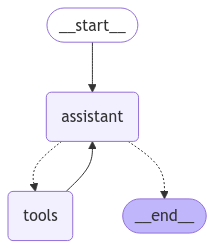

In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# Checkpointer
memory = MemorySaver()
react_graph = builder.compile(checkpointer=memory)

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
# Oggetto RunnableConfig, necessario per eseguire il grafo
# dato che abbiamo configurato il checkpointer
config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="Reclamo presentato da un certo de marinis, nome (se non ho capito male) silvano. Il codice fiscale comunicato è DMR SVN 80A01 G388M")]
messages = react_graph.invoke({"messages": messages}, config)

Passiamo ora all'output. Con il frammento di codice seguente, mostriamo tutti i messaggi

In [ ]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Reclamo presentato da un certo de marinis, nome (se non ho capito male) silvano. Il codice fiscale comunicato è DMR SVN 80A01 G388M
================================== Ai Message ==================================
Tool Calls:
  decode_tax_code (call_3y096KTlG9ph5Cn2uy9iZ9T0)
 Call ID: call_3y096KTlG9ph5Cn2uy9iZ9T0
  Args:
    tax_code: DMRSVN80A01G388M
================================= Tool Message =================================
Name: decode_tax_code

{"first_name": "FNC", "last_name": "TRR", "birth_date": "1990-01-01", "birth_city": "Pavia", "sex": "M"}
================================== Ai Message ==================================
Tool Calls:
  verify_tax_code (call_0oXmslVex4bKIFcUawVCnRrv)
 Call ID: call_0oXmslVex4bKIFcUawVCnRrv
  Args:
    first_name: Silvano
    last_name: De Marinis
    tax_code: DMRSVN80A01G388M
================================= Tool Message =================================
Na

Così prendiamo solo l'ultimo messaggio, un JSON che può essere restituito al chiamante

In [ ]:
# last element of messages
messages['messages'][-1].content

'{"first_name":"Silvano","last_name":"De Marinis","tax_code":"DMRSVN80A01G388M","birth_date":"1990-01-01","birth_city":"Pavia","gender":"M","warning":"Il codice fiscale fornito non corrisponde al nome e cognome indicati."}'

In alternativa, possiamo accedere allo stato del grafo per un particolare thread.

In [ ]:
# per eseguire il grafo in modo trasparente, possiamo chiamare direttamente react_graph.invoke
# e poi accedere allo stato del grafo
# config = {"configurable": {"thread_id": "1"}}
# react_graph.invoke({"messages": messages}, config)
state = react_graph.get_state(config)

# Scriviamo lo stato in console giusto per mostrare lo snapshot completo.
# Lo snapshot contiene molte informazioni, oltre ai messaggi, tra le quali
# - checkpoint
# - numero di token utilizzati
state

StateSnapshot(values={'messages': [HumanMessage(content='Reclamo presentato da un certo de marinis, nome (se non ho capito male) silvano. Il codice fiscale comunicato è DMR SVN 80A01 G388M', additional_kwargs={}, response_metadata={}, id='3334f095-9090-4672-8385-8eb12b84e49e'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3y096KTlG9ph5Cn2uy9iZ9T0', 'function': {'arguments': '{"tax_code":"DMRSVN80A01G388M"}', 'name': 'decode_tax_code'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 402, 'total_tokens': 427, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_5f20662549', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cdb08659-0493-48e5-aae9-f69f78e497fb-0', tool_calls=[{'

Avendo a disposizione lo stato del grafo, possiamo accedere a qualsiasi elemento in esso contenuto. Il seguente frammento considera l'ultimo messaggio, mostrando il suo contenuto.

In [ ]:
# last element of messages list
state.values['messages'][-1].content

'{"first_name":"Silvano","last_name":"De Marinis","tax_code":"DMRSVN80A01G388M","birth_date":"1990-01-01","birth_city":"Pavia","gender":"M","warning":"Il codice fiscale fornito non corrisponde al nome e cognome indicati."}'